# Accuracy Comparison

In [89]:
# Standard packages
import pickle
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import collections  as mc

# Local packages
from simulate import *

In [4]:
# Load data. Less than 2 MiB.
# Data aggregated over 5 runs, up to 100ms of simulation
with open('polybench-medium-multifidelity.pkl', 'rb') as file:
    mf = pickle.load(file)
with open('polybench-medium-normal.pkl', 'rb') as file:
    norm = pickle.load(file)

In [26]:
names = list(mf.st.keys())
y_norm_mean = [norm.st[n].IPC.mean for n in names]
y_norm_sem  = [norm.st[n].IPC.sem  for n in names]
y_mf_mean   = [mf.st[n].IPC.mean   for n in names]
y_mf_sem    = [mf.st[n].IPC.sem    for n in names]

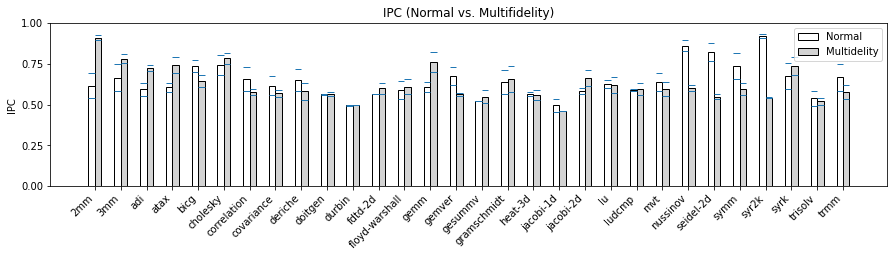

In [100]:
x = np.arange(len(names))
width = 0.25
fig, ax = plt.subplots()
ax.bar(x-(width/2), y_norm_mean, width, color='white', label='Normal', edgecolor='black')
ax.bar(x+(width/2), y_mf_mean, width, color='lightgrey', label='Multidelity', edgecolor='black')

lines = []
for i in range(len(names)):
    #lines.append([(i-(width/2),y_norm_mean[i]-y_norm_sem[i]), (i-(width/2),y_norm_mean[i]+y_norm_sem[i])])
    lines.append([(i-width,y_norm_mean[i]-y_norm_sem[i]), (i,y_norm_mean[i]-y_norm_sem[i])])
    lines.append([(i-width,y_norm_mean[i]+y_norm_sem[i]), (i,y_norm_mean[i]+y_norm_sem[i])])
    lines.append([(i,y_mf_mean[i]-y_mf_sem[i]), (i+width,y_mf_mean[i]-y_mf_sem[i])])
    lines.append([(i,y_mf_mean[i]+y_mf_sem[i]), (i+width,y_mf_mean[i]+y_mf_sem[i])])


#c = np.array([(1, 0, 0, 1), (0, 1, 0, 1), (0, 0, 1, 1)])

lc = mc.LineCollection(lines, linewidths=1)
ax.add_collection(lc)

ax.set_xticks(x)
ax.set_xticklabels(names, rotation=45, ha='right')
ax.set_ylim((0,1))
ax.set_ylabel('IPC', rotation=90)
ax.set_title('IPC (Normal vs. Multifidelity)')
ax.autoscale()
plt.legend()

#ax.yaxis.set_label_coords(-.07, 0.96)
nyticks = 5
ax.set_yticks([(1/(nyticks-1))*x for x in np.arange(nyticks)])
fig.set_size_inches((15,3))
#plt.tight_layout()